![](https://zdnet2.cbsistatic.com/hub/i/r/2014/11/28/be5ca1a7-76b6-11e4-b569-d4ae52e95e57/resize/770xauto/a1fc0cd4944953755096a9b4cd0ab5a4/credit-card-fraud-can-be-stopped-heres-how.jpg)

# Credit Card Fraud Detection<br>
### The Problem here is to label each transaction as fraudulent or genuine.The data is skewed so we have adopt a different approach to work for it.<br>I will also demonstrate the use of cross validation for hyperparameter tuning on two different classification models:-<br>
### 1.SVM<br> 2.RandomForestClassifier

### Lets Load The Library

In [2]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA,FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.preprocessing import StandardScaler 

from sklearn.cross_validation import train_test_split 
from sklearn.cross_validation import KFold 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report
import warnings
warnings.filterwarnings('ignore')

from subprocess import check_output
print(check_output(['ls','../input']).decode('utf8'))

creditcard.csv



### Getting The Data

In [3]:
data=pd.read_csv('../input/creditcard.csv')

Lets see what is the shape of the data

In [4]:
data.shape

(284807, 31)

Have a look on columns of our dataset.

In [5]:
print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


Is there any null value here..??

In [6]:
data.columns[data.isnull().any()]

Index([], dtype='object')

Great...No null value

## Target variable

In [7]:
tar=data['Class'].value_counts().reset_index()
tar.columns=['Class','Count']
temp=tar.Count
tag = (np.array(tar.index))
sizes = (np.array((temp / temp.sum())*100))
plt.figure(figsize=(10,8))

trace = go.Bar(x=tag, y=sizes)
layout = go.Layout(title='Class Distribution')
dat1 = [trace]
fig = go.Figure(data=dat1, layout=layout)
py.iplot(fig, filename="Class Distribution")

In [8]:
tar=data['Class'].value_counts().reset_index()
tar.columns=['Class','Count']
temp=tar.Count
tag = (np.array(tar.index))
sizes = (np.array((temp / temp.sum())*100))
plt.figure(figsize=(10,8))

trace = go.Pie(labels=tag, values=sizes)
layout = go.Layout(title='Class Distribution')
dat1 = [trace]
fig = go.Figure(data=dat1, layout=layout)
py.iplot(fig, filename="Class Distribution")

### As we can see, the fraud data is only 0.173% of the overall data.This shows that the data is highly imbalance and we just can't split it in random manner.

## Amount Variable

#### Lets see how the Amount variable varies for both Fraud and Normal Transaction. 

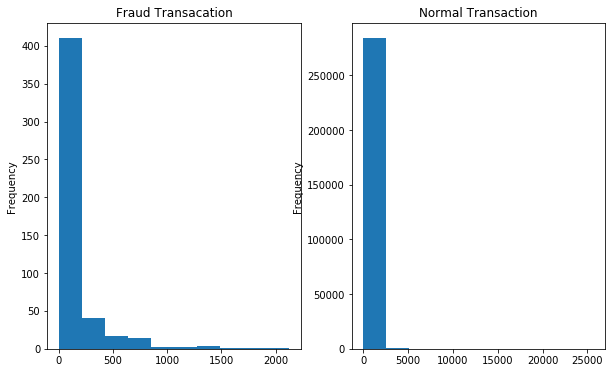

In [9]:
normal=data[data['Class']==0]
fraud=data[data['Class']==1]
plt.figure(figsize=(10,6))
plt.subplot(121)
fraud.Amount.plot.hist(title="Fraud Transacation")
plt.subplot(122)
normal.Amount.plot.hist(title="Normal Transaction")

### Have a look for distribution of other variables.

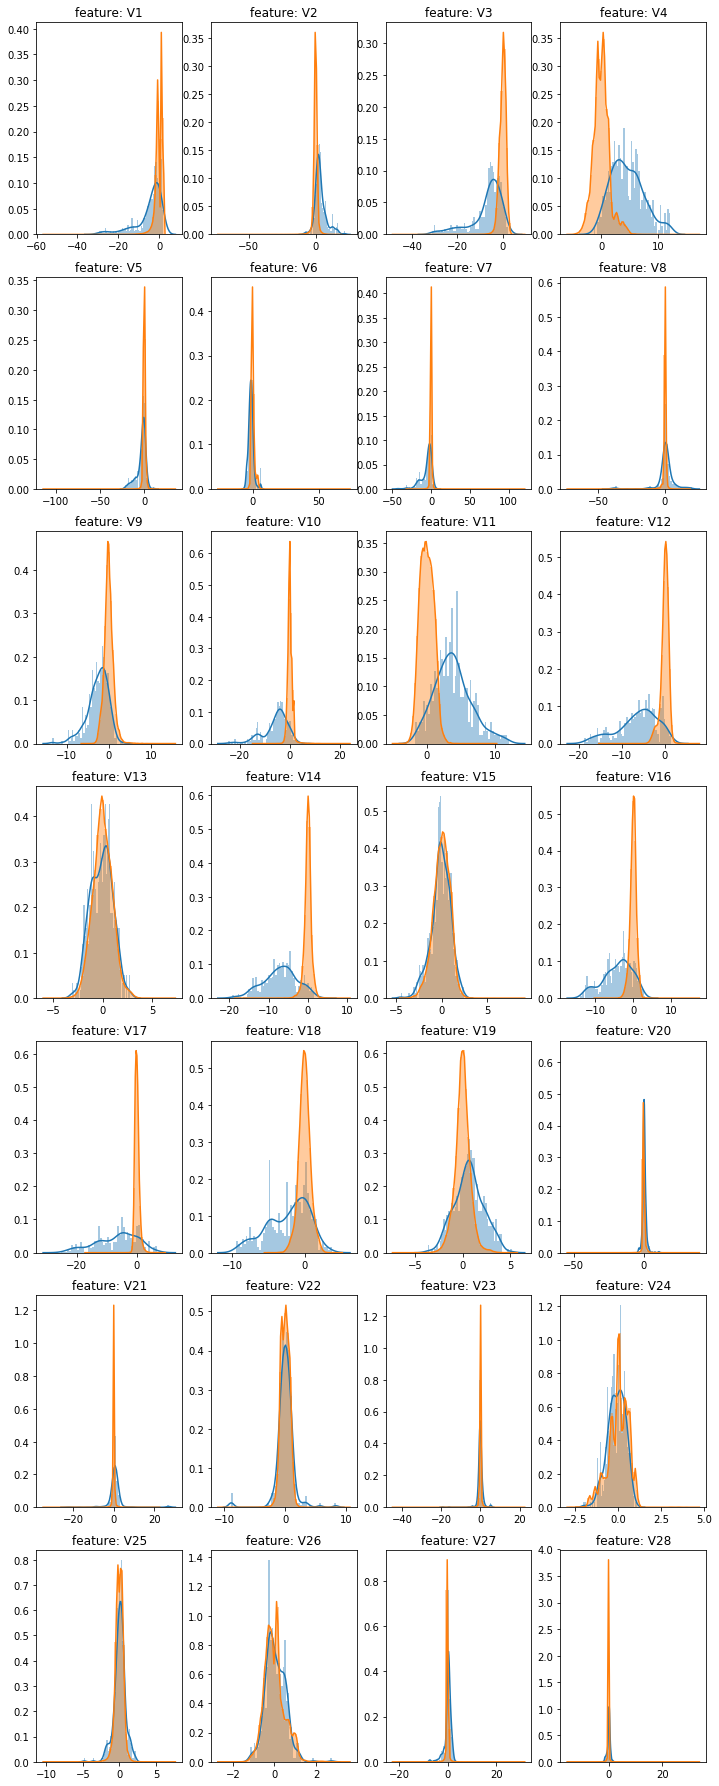

In [14]:
plt.figure(figsize=(12,8*4))
gs = gridspec.GridSpec(7, 4)
flist=[col for col in data.columns if not col in['Time','Class','Amount']]
for i, cn in enumerate(data[flist]):
    ax = plt.subplot(gs[i])
    sns.distplot(data[cn][data.Class == 1], bins=50)
    sns.distplot(data[cn][data.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(cn))

## Preprocess The data<br>
####  In this step we wil do the following thing:<br>
1.Drop features with constant value,if any.<br>
2.Drop duplicate features,if any.<br>
3.Normalize the data.<br>


In [11]:
def drop_sparse(data):
    remove=[]
    for col in data.columns:
        if data[col].std()==0:
            remove.append(col)
        
    data.drop(remove,axis=1,inplace=True)
    print(data.shape)
    return data

In [12]:
def drop_duplicate(data):
    remove = []
    c = data.columns
    for i in range(len(c)-1):
        v = data[c[i]].values
        for j in range(i+1,len(c)):
            if np.array_equal(v,data[c[j]].values):
                remove.append(c[j])
            
    data.drop(remove, axis=1, inplace=True) 
    print(data.shape)
    return data

In [13]:
def normalize_data(data):
    flist=[col for col in data.columns if not col in['Time','Class']]
    for col in flist:
         data[col] = StandardScaler().fit_transform(data[col].reshape(-1, 1))
    return data         

In [14]:
data=drop_sparse(data)
data=drop_duplicate(data)
data=normalize_data(data)

(284807, 31)
(284807, 31)


In [59]:
data=normalize_data(data)

## Feature Engineering

Lets add few more features.

In [60]:
flist = [x for x in data.columns if not x in ['Time','Class']]

flist_kmeans = []
for ncl in range(2,4):
    cls = KMeans(n_clusters=ncl)
    cls.fit_predict(data[flist].values)
    data['kmeans_cluster'+str(ncl)] = cls.predict(data[flist].values)


In [61]:
flist = [x for x in data.columns if not x in ['Time','Class']]

pca = PCA(n_components=2)
x_train_projected = pca.fit_transform(data[flist])

data.insert(1, 'PCAOne', x_train_projected[:, 0])
data.insert(1, 'PCATwo', x_train_projected[:, 1])


In [62]:
flist = [x for x in data.columns if not x in ['Time','Class']]

tsvd= TruncatedSVD(n_components=2)
x_train_projected = tsvd.fit_transform(data[flist])

data.insert(1, 'TSVDOne', x_train_projected[:, 0])
data.insert(1, 'TSVDTwo', x_train_projected[:, 1])


In [63]:
flist = [x for x in data.columns if not x in ['Time','Class']]

ica= FastICA(n_components=2)
x_train_projected = ica.fit_transform(data[flist])

data.insert(1, 'ICAOne', x_train_projected[:, 0])
data.insert(1, 'ICATwo', x_train_projected[:, 1])

 

In [27]:
data.shape

There are several ways to approach this classification problem taking into consideration this unbalance.<br>
1.Collect more data? Nice strategy but not applicable in this case<br><br>
2.Changing the performance metric:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Use the confusio nmatrix to calculate Precision, Recall<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;F1score (weighted average of precision recall)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Use Kappa - which is a classification accuracy normalized by the imbalance of the classes in the data<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ROC curves - calculates sensitivity/specificity ratio.<br><br>
3.Resampling the dataset:-<br>
&nbsp;&nbsp;&nbsp;&nbsp;Essentially this is a method that will process the data to have an approximate 50-50 ratio.<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;One way to achieve this is by OVER-sampling, which is adding copies of the under-represented class<br> (better when you have little data)<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;Another is UNDER-sampling, which deletes instances from the over-represented class (better when he have lot's of data)<br>

### Here we will use the undersampling approach

In [15]:
label=data['Class']
train1=data.drop(['Time','Class'],axis=1)
normal=data[data['Class']==0]
fraud=data[data['Class']==1]

In [16]:
from sklearn.utils import shuffle
fraud = shuffle(fraud)
normal = shuffle(normal)

In [17]:
fraud=fraud.reset_index()
fraud.drop('index',axis=1,inplace=True)

In [18]:
normal=normal.reset_index()
normal.drop('index',axis=1,inplace=True)

In [19]:
normal_train=normal.iloc[0:492,:]
normal_test=normal.iloc[492:,:]

In [20]:
frames = [normal_train,fraud]
train=pd.concat(frames)

In [21]:
from sklearn.utils import shuffle
train = shuffle(train)


In [22]:
y_train=train['Class']
x_train=train.drop(['Time','Class'],axis=1)

In [23]:
## first make a model function for modeling with confusion matrix
def model(model,features_train,features_test,labels_train,labels_test):
    clf= model
    clf.fit(features_train,labels_train)
    pred=clf.predict(features_test)
    cnf_matrix=confusion_matrix(labels_test,pred)
    print("the recall for this model is :",cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0]))
    fig= plt.figure(figsize=(6,3))# to plot the graph
    print("TP",cnf_matrix[1,1,]) # no of fraud transaction which are predicted fraud
    print("TN",cnf_matrix[0,0]) # no. of normal transaction which are predited normal
    print("FP",cnf_matrix[0,1]) # no of normal transaction which are predicted fraud
    print("FN",cnf_matrix[1,0]) # no of fraud Transaction which are predicted normal
    sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5)
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    plt.show()
    print("\n----------Classification Report------------------------------------")
    print(classification_report(labels_test,pred))

In [24]:

# Split the dataset in two equal parts
X_train, X_test, Y_train, Y_test = train_test_split(
    x_train, y_train, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, Y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.934 (+/-0.022) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.923 (+/-0.023) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.942 (+/-0.039) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.934 (+/-0.022) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.937 (+/-0.037) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.942 (+/-0.039) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.935 (+/-0.046) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.933 (+/-0.042) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.925 (+/-0.026) for {'C': 1, 'kernel': 'linear'}
0.925 (+/-0.027) for {'C': 10, 'kernel': 'linear'}
0.924 (+/-0.045) for {'C': 100, 'kernel': 'linear'}
0.922 (+/-0.044) for {'C': 1000, 'kernel': 'linear'}

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.

the recall for this model is : 0.902127659574468
TP 212
TN 246
FP 11
FN 23


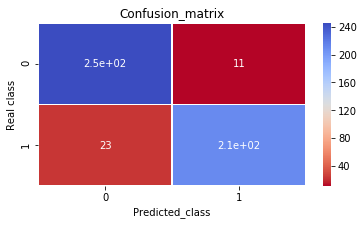


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.91      0.96      0.94       257
          1       0.95      0.90      0.93       235

avg / total       0.93      0.93      0.93       492

the recall for this model is : 0.8854489164086687
TP 286
TN 320
FP 7
FN 37


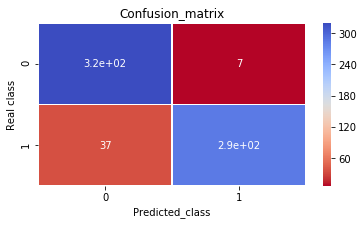


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.90      0.98      0.94       327
          1       0.98      0.89      0.93       323

avg / total       0.94      0.93      0.93       650

the recall for this model is : 0.8746594005449592
TP 321
TN 361
FP 10
FN 46


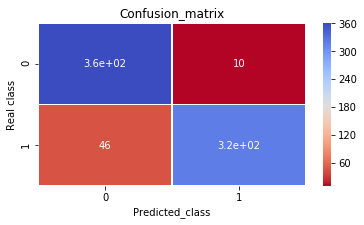


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.89      0.97      0.93       371
          1       0.97      0.87      0.92       367

avg / total       0.93      0.92      0.92       738



In [25]:
for i in ([0.5,0.66,0.75]):
    X_train, X_test, Y_train, Y_test = train_test_split(
     x_train, y_train, test_size=i)
    # now use it for modeling
    clf= SVC(kernel='rbf',C=1000,gamma=0.0001)
    model(clf,X_train,X_test,Y_train,Y_test)

the recall for this model is : 0.9207317073170732
TP 453
TN 276268
FP 8047
FN 39


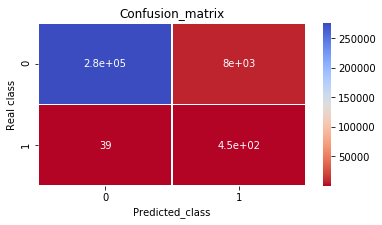


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.97      0.99    284315
          1       0.05      0.92      0.10       492

avg / total       1.00      0.97      0.98    284807



In [26]:
clf= SVC(kernel='rbf',C=1000,gamma=0.0001)
model(clf,x_train,train1,y_train,label)

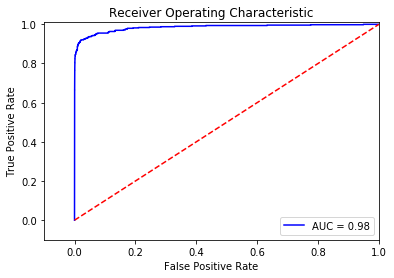

In [27]:
# ROC CURVE
lr =SVC(kernel='rbf',C=1000,gamma=0.0001,probability=True)
y_pred_undersample_score = lr.fit(x_train,y_train.values.ravel()).predict_proba(train1.values)

fpr, tpr, thresholds = roc_curve(label.values.ravel(),y_pred_undersample_score[:,1])
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Random Forest

In [28]:

# Split the dataset in two equal parts
X_train, X_test, Y_train, Y_test = train_test_split(
    x_train, y_train, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'n_estimators': [1,10,100,1000], 'max_features': ['auto','sqrt','log2'],
                    }
                    ]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, Y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'max_features': 'log2', 'n_estimators': 100}

Grid scores on development set:

0.896 (+/-0.034) for {'max_features': 'auto', 'n_estimators': 1}
0.942 (+/-0.018) for {'max_features': 'auto', 'n_estimators': 10}
0.941 (+/-0.023) for {'max_features': 'auto', 'n_estimators': 100}
0.943 (+/-0.025) for {'max_features': 'auto', 'n_estimators': 1000}
0.880 (+/-0.087) for {'max_features': 'sqrt', 'n_estimators': 1}
0.934 (+/-0.044) for {'max_features': 'sqrt', 'n_estimators': 10}
0.937 (+/-0.016) for {'max_features': 'sqrt', 'n_estimators': 100}
0.941 (+/-0.023) for {'max_features': 'sqrt', 'n_estimators': 1000}
0.890 (+/-0.040) for {'max_features': 'log2', 'n_estimators': 1}
0.933 (+/-0.038) for {'max_features': 'log2', 'n_estimators': 10}
0.943 (+/-0.027) for {'max_features': 'log2', 'n_estimators': 100}
0.943 (+/-0.025) for {'max_features': 'log2', 'n_estimators': 1000}

# Tuning hyper-parameters for rec

the recall for this model is : 0.9184549356223176
TP 214
TN 247
FP 12
FN 19


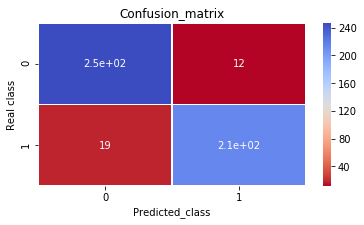


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.93      0.95      0.94       259
          1       0.95      0.92      0.93       233

avg / total       0.94      0.94      0.94       492

the recall for this model is : 0.871875
TP 279
TN 321
FP 9
FN 41


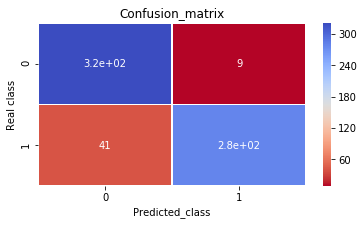


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.89      0.97      0.93       330
          1       0.97      0.87      0.92       320

avg / total       0.93      0.92      0.92       650

the recall for this model is : 0.8620689655172413
TP 325
TN 355
FP 6
FN 52


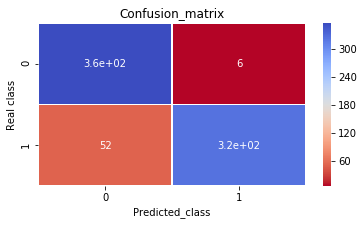


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.87      0.98      0.92       361
          1       0.98      0.86      0.92       377

avg / total       0.93      0.92      0.92       738



In [29]:
for i in ([0.5,0.66,0.75]):
    X_train, X_test, Y_train, Y_test = train_test_split(
     x_train, y_train, test_size=i)
    # now use it for modeling
    clf= RandomForestClassifier(n_estimators=100,max_features='log2')
    model(clf,X_train,X_test,Y_train,Y_test)

the recall for this model is : 1.0
TP 492
TN 277458
FP 6857
FN 0


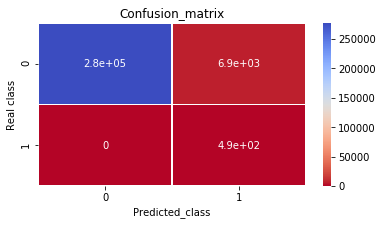


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.98      0.99    284315
          1       0.07      1.00      0.13       492

avg / total       1.00      0.98      0.99    284807



In [31]:
clf= RandomForestClassifier(n_estimators=100,max_features='log2')
model(clf,x_train,train1,y_train,label)

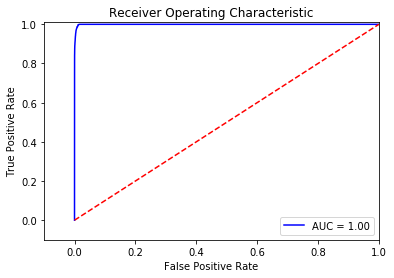

In [30]:
# ROC CURVE
lr = RandomForestClassifier(n_estimators=100,max_features='log2')
y_pred_undersample_score = lr.fit(x_train,y_train.values.ravel()).predict_proba(train1.values)

fpr, tpr, thresholds = roc_curve(label.values.ravel(),y_pred_undersample_score[:,1])
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()